# Imports

In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import confusion_matrix
import itertools

# Set random seed to ensure reproducible runs
RSEED = 50

# Load Train + Validation Data
## Elections 21

In [284]:
df_b_21 = pd.read_csv("datasets/expb_21.csv", encoding= 'Windows-1255')#.rename(columns=names_map) #.rename(index=index_names)
# print("Train data with localities and polling stations \n")
# print(df_b_21.shape)
# print(df_b_21.head())

X_b_21 = df_21.values


df_c_21 = pd.read_csv("datasets/expc_21.csv", encoding= 'Windows-1255')#.rename(columns=names_map) #.rename(index=index_names)
# print("\n\nTrain data with localities only \n")
# print(df_c_21.shape)
# print(df_c_21.head())

X_c_21 = df_c_21.values

## Elections 22

In [261]:
index_names={0:"Locality Name", 1:"Locality Code", 2:"Polling Num", 3:"BzB", 4:"Electors", 5:"Disqualified", 6:"Qualified", 
             7:"..."}

names_map={'שם ישוב':"Locality Name", 
           'סמל ישוב':"Locality Code", 
           'קלפי':"Polling Num", 
           'בזב':"BzB", 
           'מצביעים':"Electors", 
           'פסולים':"Disqualified", 
           'כשרים':"Qualified",
          } 

df_b_22 = pd.read_csv("datasets/expb_22.csv", encoding= 'Windows-1255')#.rename(columns=names_map) #.rename(index=index_names)
# print("Train data with localities and polling stations \n")
# print(df_b_22.shape)
# print(df_b_22.head())

X_b_22 = df_22.values


df_c_22 = pd.read_csv("datasets/expc_22.csv", encoding= 'Windows-1255')#.rename(columns=names_map) #.rename(index=index_names)
# print("\n\nTrain data with localities only \n")
# print(df_c_22.shape)
# print(df_c_22.head())

X_c_22 = df_c_22.values



## Join Train and Validation data together from elections 21+22

In [262]:
X_train_locality = X_c_22 #np.concatenate((X_21, X_22), axis=0)
# print("Train data with localities only: ", X_train_locality.shape, "\n", X_train_locality)

X_train_polling = X_b_22 #np.concatenate((X_21, X_22), axis=0)
# print("\n\nTrain data with pollings: ", X_train_polling.shape, "\n", X_train_polling)

## Load Test Data - Elections 23

In [263]:
df_b_23 = pd.read_csv("datasets/expb_23.csv", encoding= 'Windows-1255') #.drop([''], axis=1)
df_b_23 = df_b_23.iloc[:, :-1] #removing empty column at the end
# print("Test data with localities and polling stations \n")
# print(df_b_23.shape)
# print(df_b_23.head())

X_test_polling = df_b_23.values
# X_test_polling = np.delete(X_test_polling,[2],1) # drop Locality name column
# print(X_test_polling)


# print("\n\nTest data with localities only \n")
df_c_23 = pd.read_csv("datasets/expc_23.csv", encoding= 'Windows-1255')
df_c_23 = df_c_23.iloc[:, :-1] #removing empty column at the end
# print(df_c_23.shape)
# print(df_c_23.head())

X_test_locality = df_c_23.values
# X_test_locality = np.delete(X_test_locality,[2],1) # drop Locality name column
# print(X_test_locality)

Map all parties from 21, 22, 23 and consider unions between parties (from a file that we prepared manually)

In [297]:
# encoding_df = pd.read_excel("datasets/encoding_columns.xlsx", sheet_name='Sheet2', header=None)

# parties = index_df[0].tolist()
# encoding = index_df[1].tolist()

# # print(parties, encoding)

# parties_dict = dict(zip(parties, encoding))
# print(parties_dict)


"""Prepare a dictionary of party:code for all parties in elections round 21"""

# df_b_21 = df_b_21.drop("זך",axis=1)
# df_b_21 = df_b_21.drop("י",axis=1)
# df_b_21 = df_b_21.drop("נץ",axis=1)

parties = df_b_21.columns[7:] # columns names
# print(parties.shape)

columnsSet = set(parties)
print (len(columnsSet))
columnsSet.update(df_b_22.columns[11:])
print (len(columnsSet))
columnsSet.update(df_b_23.columns[11:])
print (len(columnsSet))

code2party = dict()
party2code = dict()

for v, k in enumerate(columnsSet,1):
    if k != '':
        code2party[v]= k
        party2code[k]= v
    
print(code2party)
print("\n",party2code)

43
56
60
{1: 'פה', 2: 'זי', 3: 'ג', 4: 'יז', 5: 'נץ', 6: 'ר', 7: 'ני', 8: 'דעם', 9: 'ז', 10: 'מרצ', 11: 'כ', 12: 'ל', 13: 'ן', 14: 'ןך', 15: 'ןנ', 16: 'ףץ', 17: 'ץ', 18: 'זנ', 19: 'זן', 20: 'אמת', 21: 'יץ', 22: 'צ', 23: 'נז', 24: 'ךק', 25: 'זכ', 26: 'ום', 27: 'יף', 28: 'ףנ', 29: 'זך', 30: 'קף', 31: 'קן', 32: 'ודעם', 33: 'ףז', 34: 'יק', 35: 'צן', 36: 'יר', 37: 'ק', 38: 'נק', 39: 'ץי', 40: 'קי', 41: 'ינ', 42: 'שס', 43: 'כף', 44: 'טב', 45: 'מחל', 46: 'זץ', 47: 'קך', 48: 'קץ', 49: 'ין', 50: 'נך', 51: 'צק', 52: 'ףי', 53: 'ץז', 54: 'נר', 55: 'רק', 56: 'נ', 57: 'כי', 58: 'ףך', 59: 'י', 60: 'כן'}

 {'פה': 1, 'זי': 2, 'ג': 3, 'יז': 4, 'נץ': 5, 'ר': 6, 'ני': 7, 'דעם': 8, 'ז': 9, 'מרצ': 10, 'כ': 11, 'ל': 12, 'ן': 13, 'ןך': 14, 'ןנ': 15, 'ףץ': 16, 'ץ': 17, 'זנ': 18, 'זן': 19, 'אמת': 20, 'יץ': 21, 'צ': 22, 'נז': 23, 'ךק': 24, 'זכ': 25, 'ום': 26, 'יף': 27, 'ףנ': 28, 'זך': 29, 'קף': 30, 'קן': 31, 'ודעם': 32, 'ףז': 33, 'יק': 34, 'צן': 35, 'יר': 36, 'ק': 37, 'נק': 38, 'ץי': 39, 'קי': 40, 'ינ': 41, 'שס'

In [298]:

names_map={'שם ישוב':"Locality Name", 
           'סמל ישוב':"Locality Code", 
           'מספר קלפי':"Polling Num", 
           'קלפי':"Polling Num",
           'בזב':"BzB", 
           'סמל ועדה':"committee code",
           'ברזל':"Barzel",
           'ריכוז':"Rikuz",
           'שופט':"Judge", 
           'מצביעים':"Voters",
           'פסולים':"Disqualified", 
           'כשרים':"Qualified",
          } 

df_b_21_encoded = df_b_21.rename(columns=party2code).rename(columns=names_map)
df_b_22_encoded = df_b_22.rename(columns=party2code).rename(columns=names_map)
df_b_23_encoded = df_b_23.rename(columns=party2code).rename(columns=names_map)

df_c_21_encoded = df_c_21.rename(columns=party2code).rename(columns=names_map)
df_c_22_encoded = df_c_22.rename(columns=party2code).rename(columns=names_map)
df_c_23_encoded = df_c_23.rename(columns=party2code).rename(columns=names_map)


In [240]:
df_b_21_encoded.head()

,Locality Name,Locality Code,Polling Num,BzB,Voters,Disqualified,Qualified,20,3,8,...,51,17,53,39,37,40,31,30,6,42
0,אבו ג'ווייעד (שבט),967,1.0,546,64,2,62,2,0,31,...,0,0,0,0,0,0,1,0,0,0
1,אבו ג'ווייעד (שבט),967,2.0,739,113,2,111,2,0,69,...,0,0,0,0,0,2,0,0,0,0
2,אבו ג'ווייעד (שבט),967,3.0,630,98,1,97,1,0,75,...,0,0,0,0,0,0,0,0,0,0
3,אבו גוש,472,1.0,518,197,6,191,4,0,36,...,0,1,0,0,1,0,0,0,0,1
4,אבו גוש,472,2.0,679,290,3,287,7,0,69,...,0,0,0,0,0,0,0,1,0,2


In [252]:
df_c_21_encoded.head()

,Locality Name,Locality Code,BzB,Voters,Disqualified,Qualified,20,3,8,26,...,51,17,53,39,37,40,31,30,6,42
0,שחר,7,516,371,0,371,17,2,0,0,...,0,0,0,0,0,0,0,0,0,33
1,תירוש,10,333,237,2,235,4,3,0,0,...,0,0,0,0,0,0,0,0,0,73
2,"ניר ח""ן",11,403,289,1,288,21,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,חצבה,13,502,403,0,403,44,2,0,0,...,0,0,0,0,3,0,0,0,0,2
4,נועם,15,302,217,2,215,1,4,0,0,...,0,0,0,0,0,0,0,0,0,25


In [241]:
df_b_22_encoded.head()

,committee code,Barzel,Locality Name,Locality Code,Polling Num,Rikuz,Judge,BzB,Voters,Disqualified,...,1,33,22,35,17,37,47,48,55,42
0,18,9797,אבו ג'ווייעד (שבט),967,1.0,1,0,559,113,2,...,9,0,0,0,0,1,0,0,0,0
1,18,9798,אבו ג'ווייעד (שבט),967,2.0,1,0,751,224,1,...,12,0,0,0,0,1,1,0,0,0
2,18,9799,אבו ג'ווייעד (שבט),967,3.0,1,0,651,205,6,...,1,0,0,0,0,1,0,0,0,0
3,2,733,אבו גוש,472,1.0,1,0,525,268,3,...,25,0,1,0,0,0,0,0,0,5
4,2,734,אבו גוש,472,2.0,1,0,686,363,6,...,33,0,0,0,0,2,1,0,0,6


In [254]:
df_c_22_encoded.head()

,committee code,Locality Name,Locality Code,BzB,Voters,Disqualified,Qualified,20,3,32,...,1,33,22,35,17,37,47,48,55,42
0,17,שחר,7,517,377,0,377,31,8,0,...,98,0,0,0,0,0,0,0,0,39
1,2,תירוש,10,332,245,0,245,1,4,0,...,6,0,0,0,0,0,0,0,0,104
2,17,"ניר ח""ן",11,406,287,0,287,32,1,1,...,94,0,0,0,0,0,0,0,0,4
3,18,חצבה,13,502,373,0,373,24,2,0,...,216,0,0,0,0,2,0,0,0,1
4,17,נועם,15,308,228,1,227,1,4,0,...,13,0,0,0,0,0,0,0,0,36


In [242]:
df_b_23_encoded.head()

,committee code,Barzel,Locality Name,Locality Code,Polling Num,Rikuz,Judge,BzB,Voters,Disqualified,...,5,38,1,33,17,37,40,47,48,42
0,18,9870,אבו גווייעד שבט,967,1.0,1,0,585,126,2,...,0,0,6,1,0,0,0,0,0,2
1,18,9871,אבו גווייעד שבט,967,2.0,1,0,764,249,2,...,0,0,0,0,0,0,0,0,2,0
2,18,9872,אבו גווייעד שבט,967,3.0,1,0,669,220,2,...,0,0,2,1,0,0,0,0,0,0
3,2,736,אבו גוש,472,1.0,1,0,530,299,7,...,0,0,11,0,0,0,0,0,0,2
4,2,737,אבו גוש,472,2.0,1,0,693,388,6,...,0,0,18,0,0,0,0,0,1,0


In [256]:
df_c_23_encoded.head()

,committee code,Locality Name,Locality Code,BzB,Voters,Disqualified,Qualified,20,3,32,...,5,38,1,33,17,37,40,47,48,42
0,18,אבו גווייעד שבט,967,2018,595,6,589,13,0,554,...,0,0,8,2,0,0,0,0,2,2
1,2,אבו גוש,472,4821,2718,36,2682,75,4,2157,...,3,2,123,0,2,0,0,1,4,14
2,6,אבו סנאן,473,9422,6090,53,6037,92,6,4458,...,3,3,752,0,2,2,1,2,4,247
3,18,אבו עבדון שבט,958,142,41,1,40,0,0,40,...,0,0,0,0,0,0,0,0,0,0
4,18,אבו קורינאת שבט,968,3037,1336,8,1328,9,0,1263,...,1,0,33,0,2,1,0,2,1,0


Deal with unions and different parties letters

In [247]:
mapper = dict()
mapper[party2code["ןך"]] = [party2code["יף"]]
mapper[party2code["יז"]] = [party2code["יק"]]
mapper[party2code["ןנ"]] = [party2code["יר"]]
mapper[party2code["ז"]] = [party2code["זן"]]
mapper[party2code["אמת"]] = [party2code["אמת"], party2code["מרצ"], party2code["נר"]]
mapper[party2code["ודעם"]] = [party2code["דעם"], party2code["ום"]]
mapper

{14: [27], 4: [34], 15: [36], 9: [19], 20: [20, 10, 54], 32: [8, 26]}

In [504]:
mapper2 = dict()
mapper2[party2code["קץ"]] = [party2code["ני"]]
mapper2[party2code["י"]] = [party2code["יר"]]
mapper2[party2code["ץ"]] = [party2code["כן"]]
mapper2[party2code["נ"]] = [party2code["נק"]]
mapper2[party2code["אמת"]] = [party2code["אמת"], party2code["מרצ"]] #TODO
mapper2

{48: [7], 59: [36], 17: [60], 56: [38], 20: [20, 10]}

In [286]:
mapper3 = dict()
mapper3[party2code["ינ"]] = [party2code["ין"]]
mapper3[party2code["נץ"]] = [party2code["כף"]]
mapper3

{41: [49], 5: [43]}

In [501]:
def handle_unions(mapper, table):
    for k,v in mapper.items():
        if(len(v) > 1):
            col = table[v[0]]
            for i in range(1,len(v)):
                col += table[v[i]]
            for item in v:
                table = table.drop(item,axis=1)
            
            table[k] = col
        else:
            table.rename(columns={k:v[0]}, inplace=True)
    return table

In [459]:
df_b_21_unioned = handle_unions(mapper, df_b_21_encoded)
print(df_b_21_unioned.columns.shape)
# df_b_21_unioned.columns

(47,)


In [461]:
df_c_21_unioned = handle_unions(mapper, df_c_21_encoded)
print(df_c_21_unioned.columns.shape)
# df_c_21_unioned.columns

(46,)


In [505]:
df_b_22_unioned = handle_unions(mapper2, df_b_22_encoded)
print(df_b_22_unioned.columns.shape)
# df_b_22_unioned.columns

(42,)


In [508]:
df_c_22_unioned = handle_unions(mapper2, df_c_22_encoded)
print(df_c_22_unioned.columns.shape)
# df_c_22_unioned.columns

(38,)


In [464]:
df_b_23_unioned = handle_unions(mapper3, df_b_23_encoded)
print(df_b_23_unioned.columns.shape)
# df_b_23_unioned.columns

(41,)


In [465]:
df_c_23_unioned = handle_unions(mapper3, df_c_23_encoded)
print(df_c_23_unioned.columns.shape)
# df_c_23_unioned.columns

(37,)


In [498]:
def handle_empty_columns(size, value):
    if value is not None:
        return value
    else:
        return [0]*size

## 1) Data with locality and polling numbers

table1 = dict()
table2 = dict()
table3 = dict()

# print(df_b_23_unioned.columns[:11])
for x in df_b_23_unioned.columns[:11]: # non-parties columns 
    table1[x] = handle_empty_columns(df_b_21_unioned.shape[0], df_b_21_unioned.get(x))
    table2[x] = handle_empty_columns(df_b_22_unioned.shape[0], df_b_22_unioned.get(x))
    table3[x] = handle_empty_columns(df_b_23_unioned.shape[0], df_b_23_unioned.get(x))

for x in code2party.keys(): # parties columns
    table1[x] = handle_empty_columns(df_b_21_unioned.shape[0], df_b_21_unioned.get(x))
    table2[x] = handle_empty_columns(df_b_22_unioned.shape[0], df_b_22_unioned.get(x))
    table3[x] = handle_empty_columns(df_b_23_unioned.shape[0], df_b_23_unioned.get(x))
    
# print(table1)
# print(table2)
# print(table3)


## 2) Data with localities only

table1_c = dict()
table2_c = dict()
table3_c = dict()

# print(df_c_22_unioned.columns[:7])
for x in df_c_23_unioned.columns[:7]: # non-parties columns 
    table1_c[x] = handle_empty_columns(df_c_21_unioned.shape[0], df_c_21_unioned.get(x))
    table2_c[x] = handle_empty_columns(df_c_22_unioned.shape[0], df_c_22_unioned.get(x))
    table3_c[x] = handle_empty_columns(df_c_23_unioned.shape[0], df_c_23_unioned.get(x))

for x in code2party.keys(): # parties columns
    table1_c[x] = handle_empty_columns(df_c_21_unioned.shape[0], df_c_21_unioned.get(x))
    table2_c[x] = handle_empty_columns(df_c_22_unioned.shape[0], df_c_22_unioned.get(x))
    table3_c[x] = handle_empty_columns(df_c_23_unioned.shape[0], df_c_23_unioned.get(x))

In [433]:
df_b_21_final = pd.DataFrame(table1)
print("אמת", df_b_21_final[party2code["אמת"]].head(1)) # check point for data
df_b_21_final.head(2)

אמת 0    14
Name: 20, dtype: int64


,committee code,Barzel,Locality Name,Locality Code,Polling Num,Rikuz,Judge,BzB,Voters,Disqualified,...,51,52,53,54,55,56,57,58,59,60
0,0,0,אבו ג'ווייעד (שבט),967,1.0,0,0,546,64,2,...,0,0,0,0,0,0,0,0,0,0
1,0,0,אבו ג'ווייעד (שבט),967,2.0,0,0,739,113,2,...,0,1,0,0,0,3,0,0,0,0


In [450]:
df_c_21_final = pd.DataFrame(table1_c)
print("אמת", df_c_21_final[party2code["אמת"]].head(1)) # check point for data
df_c_21_final.head(2)

אמת 0    71
Name: 20, dtype: int64


,committee code,Locality Name,Locality Code,BzB,Voters,Disqualified,Qualified,1,2,3,...,51,52,53,54,55,56,57,58,59,60
0,0,שחר,7,516,371,0,371,99,0,2,...,0,0,0,0,0,23,0,0,0,0
1,0,תירוש,10,333,237,2,235,5,0,3,...,0,0,0,0,0,4,0,0,0,0


In [499]:
df_b_22_final = pd.DataFrame(table2)
print("אמת", df_b_22_final[party2code["אמת"]].head(1)) # check point for data
df_b_22_final.head(2)

אמת 0    0
Name: 20, dtype: int64


,committee code,Barzel,Locality Name,Locality Code,Polling Num,Rikuz,Judge,BzB,Voters,Disqualified,...,51,52,53,54,55,56,57,58,59,60
0,18,9797,אבו ג'ווייעד (שבט),967,1.0,1,0,559,113,2,...,0,0,0,0,0,0,0,0,0,0
1,18,9798,אבו ג'ווייעד (שבט),967,2.0,1,0,751,224,1,...,0,0,0,0,0,0,2,0,0,0


In [511]:
df_c_22_final = pd.DataFrame(table2_c)
print("אמת", df_c_22_final[party2code["אמת"]].head(1)) # check point for data
df_c_22_final.head(2)

TypeError: 'int' object is not iterable

In [420]:
df_b_23_final = pd.DataFrame(table3)
print("", df_b_22_final[party2code["אמת"]].head(1)) # check point for data
df_b_23_final.head(2)

 0    0
Name: 20, dtype: int64


,committee code,Barzel,Locality Name,Locality Code,Polling Num,Rikuz,Judge,BzB,Voters,Disqualified,...,51,52,53,54,55,56,57,58,59,60
0,18,9870,אבו גווייעד שבט,967,1.0,1,0,585,126,2,...,0,0,0,0,0,0,0,0,0,0
1,18,9871,אבו גווייעד שבט,967,2.0,1,0,764,249,2,...,0,0,0,0,0,0,0,0,0,1


In [421]:
df_c_23_final = pd.DataFrame(table3_c)
print("", df_c_23_final[party2code["אמת"]].head(1)) # check point for data
df_c_23_final.head(2)

 0    13
Name: 20, dtype: int64


,committee code,Locality Name,Locality Code,BzB,Voters,Disqualified,Qualified,1,2,3,...,51,52,53,54,55,56,57,58,59,60
0,18,אבו גווייעד שבט,967,2018,595,6,589,8,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,אבו גוש,472,4821,2718,36,2682,123,0,4,...,0,0,0,0,0,0,0,0,0,0


Union 21 + 22 results for training and validation

In [391]:
df_train_polling = pd.concat([df_b_21_final, df_b_22_final], axis=0)
df_train_polling.head()

,committee code,Barzel,Locality Name,Locality Code,Polling Num,Rikuz,Judge,BzB,Voters,Disqualified,...,51,52,53,54,55,56,57,58,59,60
0,0,0,אבו ג'ווייעד (שבט),967,1.0,0,0,546,64,2,...,0,0,0,0,0,0,0,0,0,0
1,0,0,אבו ג'ווייעד (שבט),967,2.0,0,0,739,113,2,...,0,1,0,0,0,3,0,0,0,0
2,0,0,אבו ג'ווייעד (שבט),967,3.0,0,0,630,98,1,...,0,1,0,0,0,0,0,0,0,0
3,0,0,אבו גוש,472,1.0,0,0,518,197,6,...,0,0,0,0,0,0,0,0,0,0
4,0,0,אבו גוש,472,2.0,0,0,679,290,3,...,0,0,0,0,0,0,0,0,0,0


In [565]:
df_test_polling = df_b_23_final

In [512]:
df_train_locality = pd.concat([df_c_21_final, df_c_22_final], axis=0)
df_train_locality.head()

,committee code,Locality Name,Locality Code,BzB,Voters,Disqualified,Qualified,1,2,3,...,51,52,53,54,55,56,57,58,59,60
0,0,שחר,7,516,371,0,371,99,0,2,...,0,0,0,0,0,23,0,0,0,0
1,0,תירוש,10,333,237,2,235,5,0,3,...,0,0,0,0,0,4,0,0,0,0
2,0,"ניר ח""ן",11,403,289,1,288,111,0,0,...,0,0,0,0,0,17,0,0,0,0
3,0,חצבה,13,502,403,0,403,250,0,2,...,0,0,0,0,0,21,0,0,0,0
4,0,נועם,15,302,217,2,215,5,0,4,...,0,0,0,0,0,1,0,0,0,0


In [564]:
df_test_locality = df_c_23_final

Test data from 23 results

In [396]:
# סט אימון עם מספרי קלפי (בלי שמות עמודות)
X_train_polling = df_train_polling.values #df_train_polling.values #np.concatenate((df_b_21_final.values, df_b_22_final.values), axis=0) 
print(X_train_polling.shape)
print(X_train_polling[:, 2:9])

print("\n")

# סט אימון בלי מספרי קלפי (בלי שמות עמודות)
X_train_locality = df_train_locality.values #np.concatenate((df_c_21_final.values, df_c_22_final.values), axis=0) #pd.concat([df_c_21_final, df_c_22_final], axis=0)
print(X_train_locality.shape)
print(X_train_locality[:, 2:9])

(21666, 71)
[["אבו ג'ווייעד (שבט)" 967 1.0 ... 0 546 64]
 ["אבו ג'ווייעד (שבט)" 967 2.0 ... 0 739 113]
 ["אבו ג'ווייעד (שבט)" 967 3.0 ... 0 630 98]
 ...
 ['תראבין א-צאנע (שבט)' 970 1.0 ... 0 511 33]
 ['תראבין א-צאנע(ישוב)' 1346 1.0 ... 0 574 210]
 ['תרום' 778 1.0 ... 0 565 452]]


(2428, 67)
[[7 516 371 ... 371 99 0]
 [10 333 237 ... 235 5 0]
 [11 403 289 ... 288 111 0]
 ...
 [970 520 48 ... 48 4 0]
 [1346 587 206 ... 206 2 0]
 [778 576 472 ... 471 65 0]]


In [374]:
# סט בדיקה עם מספרי קלפי
X_test_locality = df_c_23_final.values
print(X_test_locality.shape)

# סט בדיקה בלי מספרי קלפי
X_test_polling = df_b_23_final.values
print(X_test_polling.shape)

(1214, 67)
(11179, 71)


# Preperation data for section 3

## הערה: הנתונים שנבנים כאן רלוונטיים רק לסעיף 3 ושיטת הבניה שונה מהשיטה מלמעלה בשל אופי השיטה שהלכנו לפיה שמחלקת את המפלגות לגושים: ימין, מרכז ושמאל

## המידה נלקח עבור הקלסטרינג רק משתי מערכות הבחירות 21 ו-22

Grouping parties by blocks (Right, Center, Left) - Election 21

In [365]:
groupby_dict = {
                'נ':'Right Block', 
                'ז':'Right Block',
                'זך':'Right Block',
                'ל':'Right Block',
                'ג':'Right Block', 
                'ףץ':'Right Block',
                'קי':'Right Block',
                'יץ':'Right Block',
                'יז':'Right Block',
                'כ':'Right Block',
                'מחל':'Right Block',
                'זץ':'Right Block',
                'טב':'Right Block',
                'שס':'Right Block',
                'זנ':'Right Block',
    
                'ץ':'Center Block',
                'קן':'Center Block',
                'נץ':'Center Block',
                'קף':'Center Block',
                'נר':'Center Block',
                'ץי':'Center Block',
                'פה':'Center Block',
                'זי':'Center Block',
                'ףך':'Center Block',
                'ךק':'Center Block',
    
                'ן':'Left Block',
                'ין':'Left Block',
                'ק':'Left Block',
                'צק':'Left Block',
                'י':'Left Block',
                'ףז':'Left Block',
                'ףי':'Left Block',
                'ןנ':'Left Block',
                'נז':'Left Block',
                'ןך':'Left Block',
                'ףנ':'Left Block',
                'ץז':'Left Block',
                'ר':'Left Block',
                'אמת':'Left Block',
                'נך':'Left Block',
                'מרץ':'Left Block',
                'דעם':'Left Block',
                'ום':'Left Block'
               }

df_blocks_21 = df_c_21.groupby(groupby_dict, axis = 1).sum() #.reset_index()
# print(df_blocks_22.shape)
# print(df_blocks_22.head())

result_21 = pd.concat([df_c_21.iloc[:,[1]], df_blocks_21], axis=1)
print(result_21.shape)
result_21.head()

(1214, 4)


,סמל ישוב,Center Block,Left Block,Right Block
0,7,108,17,237
1,10,6,4,224
2,11,123,21,134
3,13,258,47,81
4,15,7,1,207


Grouping parties by blocks (Right, Center, Left) - Election 22

In [8]:

groupby_dict = {
                'ג':'Right Block', 
                'הי':'Right Block',
                'הפ':'Right Block',
                'ז':'Right Block',
                'זך':'Right Block', 
                'טב':'Right Block',
                'כף':'Right Block',
                'ל':'Right Block',
                'מחל':'Right Block',
                'שס':'Right Block',
    
                'יק':'Center Block',
                'כ':'Center Block',
                'כן':'Center Block',
                'נ':'Center Block',
                'ני':'Center Block',
                'נץ':'Center Block',
                'פה':'Center Block',
                'פנ':'Center Block',
                'צ':'Center Block',
    
                'אמת':'Left Block',
                'הק':'Left Block',
                'ודעם':'Left Block',
                'מרץ':'Left Block',
                'נק':'Left Block',
                'ףז':'Left Block',
                'פי':'Left Block',
                'פץ':'Left Block',
                'נק':'Left Block',
                'צפ':'Left Block',
                'צק':'Left Block',
                'ץ':'Left Block',
                'קנ':'Left Block',
                'רק':'Left Block'
               }

df_blocks_22 = df_c_22.groupby(groupby_dict, axis = 1).sum() #.reset_index()
# print(df_blocks_22.shape)
# print(df_blocks_22.head())

result_22 = pd.concat([df_c_22.iloc[:,[2]], df_blocks_22], axis=1)
print(result_22.shape)
print(result_22.head())

(1214, 4)
   סמל ישוב  Center Block  Left Block  Right Block
0         7            98          31          217
1        10             6           1          217
2        11            95          33           90
3        13           216          24           67
4        15            13           1          211


Joining blocks data from both elections 21 + 22 togrther

In [9]:
# result = np.concatenate((result_21, result_22), axis=0)
result = pd.concat([result_21, result_22], axis=0)
print("Train data: ", result.shape, "\n", result.head())

Train data:  (2428, 4) 
    סמל ישוב  Center Block  Left Block  Right Block
0         7           108          17          237
1        10             6           4          224
2        11           123          21          134
3        13           258          47           81
4        15             7           1          207


## Load Localities Data

In [375]:
bycode_df = pd.read_excel("datasets/bycode2018.xlsx", usecols=[1, 14]) # עמודות: סמל ישוב + צורת יישוב שוטפת
bycode_df.head()
# print(bycode_df.iloc[:, [1,14]])
# cities = bycode_df.values[:,[1,14]] # סמל ישוב + צורת ישוב
# print(cities.shape)
# print(cities)

,סמל ישוב,צורת יישוב שוטפת
0,967,460
1,472,280
2,473,270
3,935,460
4,958,460


## Load Localities Index

In [376]:
# example: DID = pd.read_excel(file1, sheet_name=0, header=None, usecols=[0, 1, 6], names=['A', 'ID', 'B'], 
# dtype={2:str}, skiprows=10)

index_df = pd.read_excel("datasets/index 2018.xlsx", sheet_name='צורת יישוב', header=None, usecols=[0, 2], 
                         names=['צורת יישוב', 'צורת יישוב שוטפת']) #.rename(index={0: 'סמל ישוב'})
index_df = index_df.iloc[3:,:]
index_df = index_df.dropna()
print(index_df.shape)
index_df.head()
# print(index_df.columns)
# print(index_df.iloc[3:,:])

# indexes = index_df.values[:,[0,2]]
# print(indexes.shape)
# print(indexes)

(28, 2)


,צורת יישוב,צורת יישוב שוטפת
4,"יישובים יהודיים 500,000 תושבים ומעלה",120
5,"יישובים יהודיים 499,999-200,000 תושבים",130
6,"יישובים יהודיים 199,999-100,000 תושבים",140
7,"יישובים יהודיים 99,999-50,000 תושבים",150
8,"יישובים לא יהודיים 99,999-50,000 תושבים",250


## Data Preperation - Join Dataframes (for section 3)

In [377]:
# dat = df_21.join(bycode_df.set_index('סמל ישוב'), on='סמל ישוב')
dat = pd.merge(result, bycode_df, on='סמל ישוב', how='inner') # עמודה 1: סמל ישוב
# print(dat.shape)
# print(dat)

dat = pd.merge(dat, index_df, on='צורת יישוב שוטפת', how='left')
print(dat.shape)
dat.head()

(2424, 6)


,סמל ישוב,Center Block,Left Block,Right Block,צורת יישוב שוטפת,צורת יישוב
0,7,108,17,237,310,מושבים
1,7,98,31,217,310,מושבים
2,10,6,4,224,310,מושבים
3,10,6,1,217,310,מושבים
4,11,123,21,134,310,מושבים


נסיון לקטלג את התוצאות לפי צורת ישוב מצומצת, כלומר לא לי קוד צורת ישוב אלא לפי ישובים כפריים או עירוניים למשל.
או לפי ישובים יהודיים ולא יהודיים.
אבל לאחר בחינת הנתונים הועדף להישאר עם קוד צורת הישוב כמו שהוא ומידע זה לא היה בשימוש בהמשך הפתרון

In [13]:
"""
dict_by_size = {
                '310':'Rural locality', 
                '320':'Rural locality',
                '330':'Rural locality',
                '340':'Rural locality',
                '440':'Rural locality', 
                '370':'Rural locality',
                '350':'Rural locality',
                '450':'Rural locality',
                '460':'Rural locality',
             
                '120':'Urban locality', 
                '130':'Urban locality',
                '140':'Urban locality',
                '150':'Urban locality',
                '160':'Urban locality', 
                '170':'Urban locality',
                '180':'Urban locality',
                '190':'Urban locality',
                '191':'Urban locality',
                '192':'Urban locality',
                '193':'Urban locality', 
                '250':'Urban locality',
                '260':'Urban locality',
                '270':'Urban locality',
                '280':'Urban locality',
                '290':'Urban locality',
    
                '510':'Other place',
                '520':'Other place',
                '530':'Other place',
                }

dict_by_nationality = {
                250:0, #'Non-Jewish locality', 
                260:0, #'Non-Jewish locality'
                270:0, #'Non-Jewish locality'
                280:0, #'Non-Jewish locality'
                290:0, #'Non-Jewish locality'
                440:0, #'Non-Jewish locality'
                450:0, #'Non-Jewish locality'
                460:0, #'Non-Jewish locality'
             
                120:1, #'Jewish locality', 
                130:1, #'Jewish locality', 
                140:1, #'Jewish locality', 
                150:1, #'Jewish locality', 
                160:1, #'Jewish locality',  
                170:1, #'Jewish locality', 
                180:1, #'Jewish locality', 
                190:1, #'Jewish locality', 
                191:1, #'Jewish locality', 
                192:1, #'Jewish locality', 
                193:1, #'Jewish locality',  
                310:1, #'Jewish locality', 
                320:1, #'Jewish locality', 
                330:1, #'Jewish locality', 
                340:1, #'Jewish locality', 
                350:1, #'Jewish locality', 
                370:1, #'Jewish locality', 
    
                510:2, #'Other place',
                520:2, #'Other place',
                530:2, #'Other place',
                }

new_dat = dat
# new_dat['צורת יישוב שוטפת'].apply(dict_by_nationality.get)
# new_dat = new_dat['צורת יישוב שוטפת'].map(dict_by_nationality).fillna(new_dat['צורת יישוב שוטפת'])
new_dat['צורת יישוב שוטפת'].replace(dict_by_nationality, inplace=True)

print(new_dat.head())
"""

   סמל ישוב  Center Block  Left Block  Right Block  צורת יישוב שוטפת  \
0         7           108          17          237                 1   
1         7            98          31          217                 1   
2        10             6           4          224                 1   
3        10             6           1          217                 1   
4        11           123          21          134                 1   

  צורת יישוב  
0    מושבים   
1    מושבים   
2    מושבים   
3    מושבים   
4    מושבים   


In [50]:
X = dat.values[:, :-1] # נתוני הצבעה עבור המפלגות השונות + קוד צורת הישוב
# print(X.shape)
# print(X)

X_r_train = X[:, 1] # גוש הימין
X_c_train = X[:, 3] # גוש המרכז
X_l_train = X[:, 2] # גוש השמאל

X_clust_train = X[:, 0] # סמל ישוב
y_clust_train = X[:, -1] # קוד צורת ישוב
print("--------------------------")
print("\nX_r_train: \n",X_r_train, "\nX_c_train: \n",X_c_train, "\nX_l_train: \n",X_l_train, "\ny_train: \n", y_clust_train)

--------------------------

X_r_train: 
 [108 98 6 ... 4081 3753 5] 
X_c_train: 
 [237 217 224 ... 2223 2180 115] 
X_l_train: 
 [17 31 4 ... 796 669 6] 
y_train: 
 [310 310 310 ... 170 170 370]


# IMPORTANT

Used data from files with localities only. Got better results and the graphs looked more understandable when using data of files without pollings.

# ASSUMPTION

I assumed that I can join parties by their politcs attitude and combine them into blocks (Right, Center, Left) rather than working with individual parties. It will make the results clearer and easy to understand.

# 3. Clustering
## 3.1. Using GMM

מקרא
                                            צורת יישוב צורת יישוב שוטפת
4                יישובים יהודיים 500,000 תושבים ומעלה              120
5              יישובים יהודיים 499,999-200,000 תושבים              130
6              יישובים יהודיים 199,999-100,000 תושבים              140
7                יישובים יהודיים 99,999-50,000 תושבים              150
9                יישובים יהודיים 49,999-20,000 תושבים              160
11               יישובים יהודיים 19,999-10,000 תושבים              170
13                 יישובים יהודיים 9,999-5,000 תושבים              180
15                 יישובים יהודיים 4,999-2,000 תושבים              190
16                          מושבים 4,999-2,000 תושבים              191
17                 מושבים שיתופיים 4,999-2,000 תושבים              192
18                         קיבוצים 4,999-2,000 תושבים              193
8             יישובים לא יהודיים 99,999-50,000 תושבים              250
10            יישובים לא יהודיים 49,999-20,000 תושבים              260


Text(0, 0.5, 'Locality type')

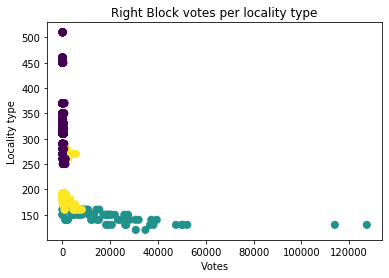

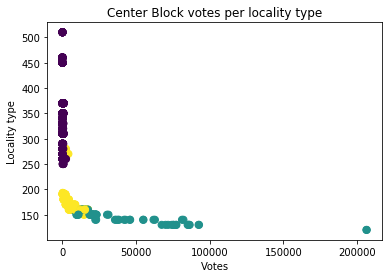

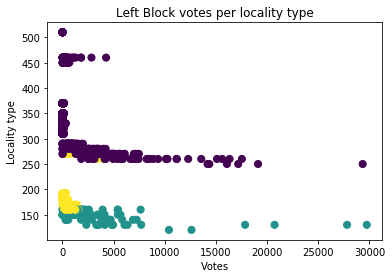

In [51]:
gmm = GaussianMixture(n_components=3).fit(X)
labels = gmm.predict(X)
# print("Labels: ", labels)

print("מקרא\n", index_df.sort_values(by=['צורת יישוב שוטפת']))

plt.figure(1)
plt.scatter(X_r_train, y_clust_train, c=labels, s=50, cmap='viridis');
plt.title('Right Block votes per locality type')
plt.xlabel('Votes')
plt.ylabel('Locality type')
# plt.legend(loc='best')


plt.figure(2)
plt.scatter(X_c_train, y_clust_train, c=labels, s=50, cmap='viridis');
plt.title('Center Block votes per locality type')
plt.xlabel('Votes')
plt.ylabel('Locality type')

plt.figure(3)
plt.scatter(X_l_train, y_clust_train, c=labels, s=50, cmap='viridis');
plt.title('Left Block votes per locality type')
plt.xlabel('Votes')
plt.ylabel('Locality type')

## 3.2. Using KMeans

In [16]:
def elbow_met(df):
    from scipy.spatial.distance import cdist
    # k means determine k
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(df)
        kmeanModel.fit(df)
        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Within groups sum of squares')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

Using elbow method to help deciding what is the number of clusters

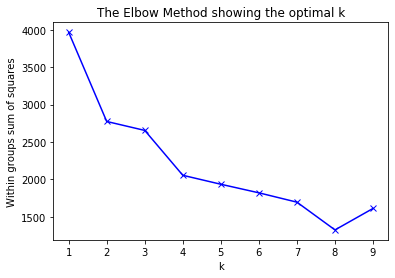

In [17]:
elbow_met(X)

In [52]:
kmeans = KMeans(n_clusters=3).fit(X) # TODO - number of clusters
centroids = kmeans.cluster_centers_
# print(centroids)

מקרא
                                            צורת יישוב צורת יישוב שוטפת
4                יישובים יהודיים 500,000 תושבים ומעלה              120
5              יישובים יהודיים 499,999-200,000 תושבים              130
6              יישובים יהודיים 199,999-100,000 תושבים              140
7                יישובים יהודיים 99,999-50,000 תושבים              150
9                יישובים יהודיים 49,999-20,000 תושבים              160
11               יישובים יהודיים 19,999-10,000 תושבים              170
13                 יישובים יהודיים 9,999-5,000 תושבים              180
15                 יישובים יהודיים 4,999-2,000 תושבים              190
16                          מושבים 4,999-2,000 תושבים              191
17                 מושבים שיתופיים 4,999-2,000 תושבים              192
18                         קיבוצים 4,999-2,000 תושבים              193
8             יישובים לא יהודיים 99,999-50,000 תושבים              250
10            יישובים לא יהודיים 49,999-20,000 תושבים              260


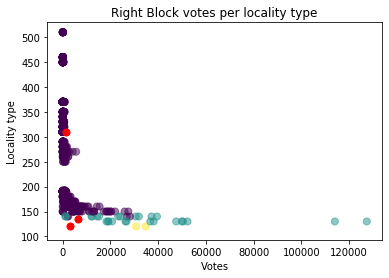

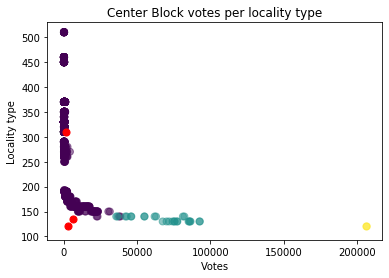

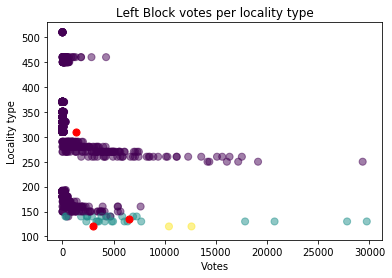

In [53]:
print("מקרא\n", index_df.sort_values(by=['צורת יישוב שוטפת']))

plt.figure(1)
plt.scatter(X_r_train, y_clust_train, c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, -1], c='red', s=50)
plt.title('Right Block votes per locality type')
plt.xlabel('Votes')
plt.ylabel('Locality type')

plt.figure(2)
plt.scatter(X_c_train, y_clust_train, c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, -1], c='red', s=50)
plt.title('Center Block votes per locality type')
plt.xlabel('Votes')
plt.ylabel('Locality type')

plt.figure(3)
plt.scatter(X_l_train, y_clust_train, c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, -1], c='red', s=50)
plt.title('Left Block votes per locality type')
plt.xlabel('Votes')
plt.ylabel('Locality type')

plt.show()



## CONCLUSION

In my case when working with blocks of parties instead of individuals, I can see that both methods (GMM & Kmeans) gave similar results; <br>
so I can't specify or preffer one over the other, specially because I used the <b>elbow method</b> to help me specifying number of clusters.
<br><br>

<b>Left Block Figure:</b>
<br>
Differently from both right and center blocks we can see that in left blocks the number of voters is drasticaly higher in localities types between 250-300.<br>
When checking the key map (legend) of localities types, I can see that these localities types codes referres to Non-Jowesh localitis; which <b>MAKES SENSE</b>.

<br><br>
<b>Center and Right Blocks Figures:</b>
<br>
In both they got very few votes from Non-Jowesh localities, and the big amount of votes was in localities types domain 100-200 which refferes to large urban localities (located in the center region of Israel usually)


# 4) Random Forest

## IMPORTANT

I got better mse and regression results when working with files with polling numbers rather than files with locality only.

In [513]:
X_4_train_polling = X_train_polling[:, 3:9] # נתוני ישוב וקלפי + מספר מצביעים 
y_4_train_polling = X_train_polling[:, 10] #.ravel() # reshape from (n,1) to (n,) # קולות כשרים
y_4_train_polling = y_4_train_polling.astype('int')

print("X_4_train_polling: \n", X_4_train_polling.shape, X_4_train_polling)
print("y_4_train_polling: \n", y_4_train_polling.shape, y_4_train_polling)


# Only locality without polling number
X_4_train_locality = X_train_locality[:, 2:5] # נתוני ישוב + מספר מצביעים 
y_4_train_locality = X_train_locality[:, 6] #.ravel() # reshape from (n,1) to (n,) # קולות כשרים
# X_4_train_locality = np.concatenate((X_train_locality[:, 2:5], X_train_locality[:, 7:-2]), axis=1) # נתוני ישוב + מספר קולות 
# y_4_train_locality = X_train_locality[:, 6] #.ravel() # reshape from (n,1) to (n,) # מס קולות כשרים

y_4_train_locality = y_4_train_locality.astype('int')
# y_4_train = y_4_train.reshape(-1, 1)

print("\n\nX_4_train_locality: \n", X_4_train_locality.shape, X_4_train_locality)
print("y_4_train_locality: \n", y_4_train_locality.shape, y_4_train_locality)
    

X_4_train_polling: 
 (21666, 6) [[967 1.0 0 0 546 64]
 [967 2.0 0 0 739 113]
 [967 3.0 0 0 630 98]
 ...
 [970 1.0 1 0 511 33]
 [1346 1.0 1 0 574 210]
 [778 1.0 1 0 565 452]]
y_4_train_polling: 
 (21666,) [ 62 111  97 ...  33 205 452]


X_4_train_locality: 
 (2428, 3) [[7 516 371]
 [10 333 237]
 [11 403 289]
 ...
 [970 520 48]
 [1346 587 206]
 [778 576 472]]
y_4_train_locality: 
 (2428,) [371 235 288 ...  48 206 471]


In [549]:
"""
# חיפה, איילת השחר, אילת, סכנין וקצרין
df_b_4_filtered = df_b_23.loc[df_b_23['שם ישוב'].isin(['קצרין', 'סחנין', 'אילת', 'איילת השחר', 'חיפה'])] 
# print(df_4_fildf_b_4_filteredtered)
X_23_filtered = df_b_4_filtered.values #.drop(['שם ישוב'], axis=1).values
# print(X_23_filtered)

X_4_test_polling = X_23_filtered[:, 3:10] #.reshape(-1, 1) # סמל ישוב
y_4_test_polling = X_23_filtered[:, 10] #

print("X_4_test_polling: ",  X_4_test_polling.shape, "\n", X_4_test_polling)
print("y_4_test_polling: ",  y_4_test_polling.shape, y_4_test_polling)


df_c_4_filtered = df_c_23.loc[df_c_23['שם ישוב'].isin(['קצרין', 'סחנין', 'אילת', 'איילת השחר', 'חיפה'])] 
# print(df_c_4_filtered)
X_23_filtered = df_c_4_filtered.values #.drop(['שם ישוב'], axis=1).values
# print(X_23_filtered) 

# Only locality without polling numbers
X_4_test_locality = X_23_filtered[:, [2, 4, 5]] #.reshape(-1, 1) # סמל ישוב
y_4_test_locality = X_23_filtered[:, 6] # 
# X_4_test_locality = np.concatenate((X_23_filtered[:, 2:5], X_23_filtered[:, 7:]), axis=1)  #.reshape(-1, 1) # סמל ישוב
# y_4_test_locality = X_23_filtered[:, 6] # 
"""

## Without filtering

# מידע כולל מספרי כלפי
X_4_test_polling = X_test_polling[:, 3:9] #.reshape(-1, 1) # נתוני ישוב
y_4_test_polling = X_test_polling[:, 10] # קולות כשרים


print("\nX_4_test_polling: ",  X_4_test_polling.shape, "\n", X_4_test_polling)
print("\ny_4_test_polling: ",  y_4_test_polling.shape, y_4_test_polling)

# מידע עם נתוני ישוב בלבד
X_4_test_locality = X_test_locality[:, 2:5] #.reshape(-1, 1) # נתוני ישוב
y_4_test_locality = X_test_locality[:, 6] # קולות כשרים


print("\nX_4_test_locality: ",  X_4_test_locality.shape, "\n", X_4_test_locality)
print("\ny_4_test_locality: ",  y_4_test_locality.shape, y_4_test_locality)



X_4_test_polling:  (11179, 6) 
 [[967 1.0 1 0 585 126]
 [967 2.0 1 0 764 249]
 [967 3.0 1 0 669 220]
 ...
 [970 1.0 1 0 520 48]
 [1346 1.0 1 0 587 206]
 [778 1.0 1 0 576 472]]

y_4_test_polling:  (11179,) [124 247 218 ... 48 206 471]

X_4_test_locality:  (1214, 3) 
 [[967 2018 595]
 [472 4821 2718]
 [473 9422 6090]
 ...
 [970 520 48]
 [1346 587 206]
 [778 576 472]]

y_4_test_locality:  (1214,) [589 2682 6037 ... 48 206 471]


In [407]:
# Hyperparameter grid
# param_grid = {
#     'n_estimators': [100, 150, 200, 250],#The number of trees in the forest.
#     'max_depth': [None, 50, 60, 70] ,#The maximum depth of the tree.
#     'max_features': ['sqrt', None],#he number of features to consider when looking for the best split
#     'min_samples_split': [2, 5, 10],#The minimum number of samples required to split an internal node
#     'bootstrap': [True, False]#Whether bootstrap samples are used when building trees.
# }
param_grid = {
    'n_estimators': [100, 150],#The number of trees in the forest.
    'max_depth': [50] ,#The maximum depth of the tree.
    'max_features': ['sqrt'],#he number of features to consider when looking for the best split
    'min_samples_split': [5, 10],#The minimum number of samples required to split an internal node
    'bootstrap': [True]#Whether bootstrap samples are used when building trees.
}

# Estimator for use in grid search
estimator = RandomForestRegressor(random_state = RSEED)

# Create the random search model
# rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, cv = 5, 
#                         n_iter = 1, verbose = 1, random_state=RSEED)

# Create Decision Tree regressor with best parameters
gs1 = GridSearchCV(estimator, param_grid, cv=10)
gs2 = GridSearchCV(estimator, param_grid, cv=10)


## IMPORTANT

I'm going to perform 2 runs, one with data that includes localities data only and the other with data that includes the polling numbers as well, and COMPARE between them

## 4.1. Using data with localities only (without pollings)

In [408]:
# Fit 
gs1.fit(X_4_train_locality, y_4_train_locality)

gs1.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'n_estimators': 150}

In [521]:
# Get indexes of filtered rows - to be used later on fo filtering predictions
df_c_4_filtered = df_c_23_final.loc[df_c_23_final['Locality Name'].isin(['קצרין', 'סחנין', 'אילת', 'איילת השחר', 'חיפה'])] 
df_c_4_filtered.index

Int64Index([59, 63, 406, 870, 1035], dtype='int64')

In [522]:
best_model1 = gs1.best_estimator_

# train_rf_predictions = best_model.predict(X_4_train)
# train_rf_probs = best_model.predict_proba(X_4_train)[:, 1]
# print("train_rf_predictions", train_rf_predictions.shape, train_rf_predictions)
# print("train_rf_probs", train_rf_probs.shape, train_rf_probs)

#TODO
rf_predictions1 = best_model1.predict(X_4_test_locality)
# rf_probs = best_model.predict_proba(X_4_test)[:, 1]
# print("rf_probs", rf_probs.shape, rf_probs)

      
print('Mean Squared Error:', metrics.mean_squared_error(y_4_test_locality, rf_predictions1))

filtered_predictions = np.array(rf_predictions1)[df_c_4_filtered.index] 
filtered_labels = np.array(y_4_test_locality)[df_c_4_filtered.index] 

print("rf_predictions", filtered_predictions.shape, filtered_predictions)
print("test labels: ", filtered_labels.shape, filtered_labels)

Mean Squared Error: 7404554.066665929
rf_predictions (5,) [   590.75024603  23936.07669577 152486.1961455   16905.84566931
   3572.96222751]
test labels:  (5,) [585 22636 144625 17085 3498]


<Figure size 432x288 with 0 Axes>

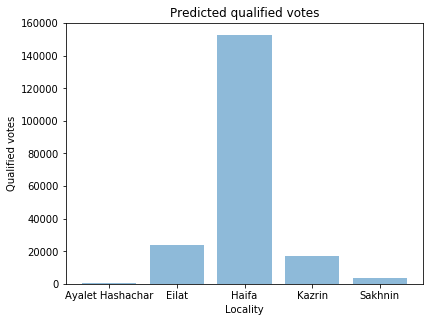

In [524]:
# plt.figure(1)
# plt.scatter(y_4_test_locality, rf_predictions, s=30, alpha=0.5)
# plt.title('Predicted Qualified values regression')
# plt.xlabel('Test labels')
# plt.ylabel('Predicted labels')

plt.figure(2)
plt.figure(figsize=(6.4,4.8))
columns_4 = ('Ayalet Hashachar', 'Eilat', 'Haifa', 'Kazrin', 'Sakhnin')
y_pos = np.arange(len(columns_4))
plt.bar(y_pos, filtered_predictions, align='center', alpha=0.5)
plt.xticks(y_pos, columns_4)
plt.xlabel('Locality')
plt.ylabel('Qualified votes')
plt.title('Predicted qualified votes')
plt.show()

# plt.figure(3)
# plt.plot(X_4_test[:, 0], rf_predictions)
# plt.xlabel('Locality')
# plt.ylabel('Qualified votes')
# plt.title('Predicted qualified votes')
# plt.show()

# fig, ax = plt.subplots()
# # ax.plot(years_b30, Geb_b30, label='Prices 2008-2018', color='red')
# ax.plot(X_4_test[:, 0], rf_predictions, color = 'blue')
# # legend = ax.legend(loc='center right', fontsize='x-large')
# plt.xlabel('Locality')
# plt.ylabel('Qualified votes')
# plt.title('Predicted qualified votes')
# plt.show()


## 4.2. Using data with pollings (not only localities)

In [526]:
# Fit 
gs2.fit(X_4_train_polling, y_4_train_polling)

gs2.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'n_estimators': 100}

In [528]:
# Get indexes of filtered rows - to be used later on fo filtering predictions
df_b_4_filtered = df_b_23_final.loc[df_b_23_final['Locality Name'].isin(['קצרין', 'סחנין', 'אילת', 'איילת השחר', 'חיפה'])] 
df_b_4_filtered.index

Int64Index([ 309,  310,  315,  316,  317,  318,  319,  320,  321,  322,
            ...
            8512, 8513, 8514, 8515, 8516, 8517, 8518, 8519, 8520, 8521],
           dtype='int64', length=534)

In [529]:
best_model2 = gs2.best_estimator_

# train_rf_predictions = best_model.predict(X_4_train)
# train_rf_probs = best_model.predict_proba(X_4_train)[:, 1]
# print("train_rf_predictions", train_rf_predictions.shape, train_rf_predictions)
# print("train_rf_probs", train_rf_probs.shape, train_rf_probs)

#TODO
rf_predictions2 = best_model2.predict(X_4_test_polling)
rf_predictions2 = np.around(rf_predictions2, 0)
# rf_probs = best_model.predict_proba(X_4_test)[:, 1]
# print("rf_probs", rf_probs.shape, rf_probs)
# print("rf_predictions", rf_predictions2.shape, rf_predictions2)
# print("test labels: ", y_4_test_polling.shape, y_4_test_polling)
 
print('Mean Squared Error:', metrics.mean_squared_error(y_4_test_polling, rf_predictions2))

filtered_predictions2 = np.array(rf_predictions2)[df_b_4_filtered.index] 
filtered_labels2 = np.array(y_4_test_polling)[df_b_4_filtered.index]



Mean Squared Error: 144.48027551659362


In [532]:
# df_table_4 = df_b_4_filtered.iloc[:, [2, 3, 4, 8, 9, 10]].sort_values(['סמל ישוב', 'קלפי'], ascending=[True, True]) #.reset_index()
df_table_4 = df_b_4_filtered.iloc[:, [2, 3, 4, 8, 9, 10]].sort_values(['Locality Code', 'Polling Num'], ascending=[True, True]) #.reset_index()
columns_4_2 = df_table_4.columns
# print(columns)
columns_4_2 = ['Locality name', 'Locality code', 'Polling number', 'Voters', 'Disqualified votes', 'Qualified votes', 'Predicted Qualified votes']

data_4 = df_table_4.values
# data = data[:, :-1]
data_4 = np.concatenate((data_4, filtered_predictions2.reshape(-1, 1)), axis=1)
# print(data)

<Figure size 1152x648 with 0 Axes>

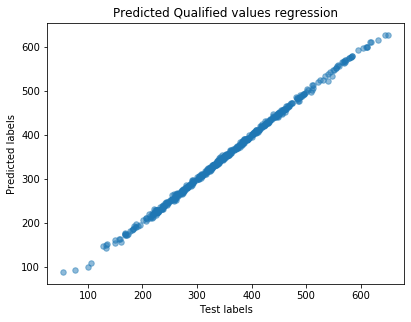

<Figure size 1152x648 with 0 Axes>

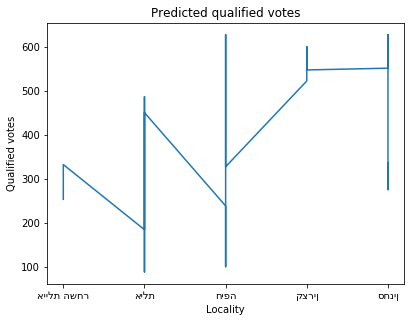

In [543]:
# plt.figure(figsize=(6.4,4.8))
# plt.rcParams["figure.figsize"] = [16,9]

plt.figure(1)
plt.figure(figsize=(6.4,4.8))
plt.scatter(filtered_labels2, filtered_predictions2, s=30, alpha=0.5)
plt.title('Predicted Qualified values regression')
plt.xlabel('Test labels')
plt.ylabel('Predicted labels')
plt.show()

# plt.figure(2)
# objects = ('Ayalet Hashachar', 'Eilat', 'Haifa', 'Kazrin', 'Sakhnin')
# y_pos = np.arange(len(objects))
# plt.bar(y_pos, rf_predictions, align='center', alpha=0.5)
# plt.xticks(y_pos, objects)
# plt.xlabel('Locality')
# plt.ylabel('Qualified votes')
# plt.title('Predicted qualified votes')
# plt.show()

plt.figure(3)
plt.figure(figsize=(6.4,4.8))
plt.plot(data_4[:, 0], filtered_predictions2) #X_4_test_polling[:, 0]
plt.xlabel('Locality')
plt.ylabel('Qualified votes')
plt.title('Predicted qualified votes')
plt.show()

# fig, ax = plt.subplots()
# # ax.plot(years_b30, Geb_b30, label='Prices 2008-2018', color='red')
# ax.plot(X_4_test[:, 0], rf_predictions, color = 'blue')
# # legend = ax.legend(loc='center right', fontsize='x-large')
# plt.xlabel('Locality')
# plt.ylabel('Qualified votes')
# plt.title('Predicted qualified votes')
# plt.show()

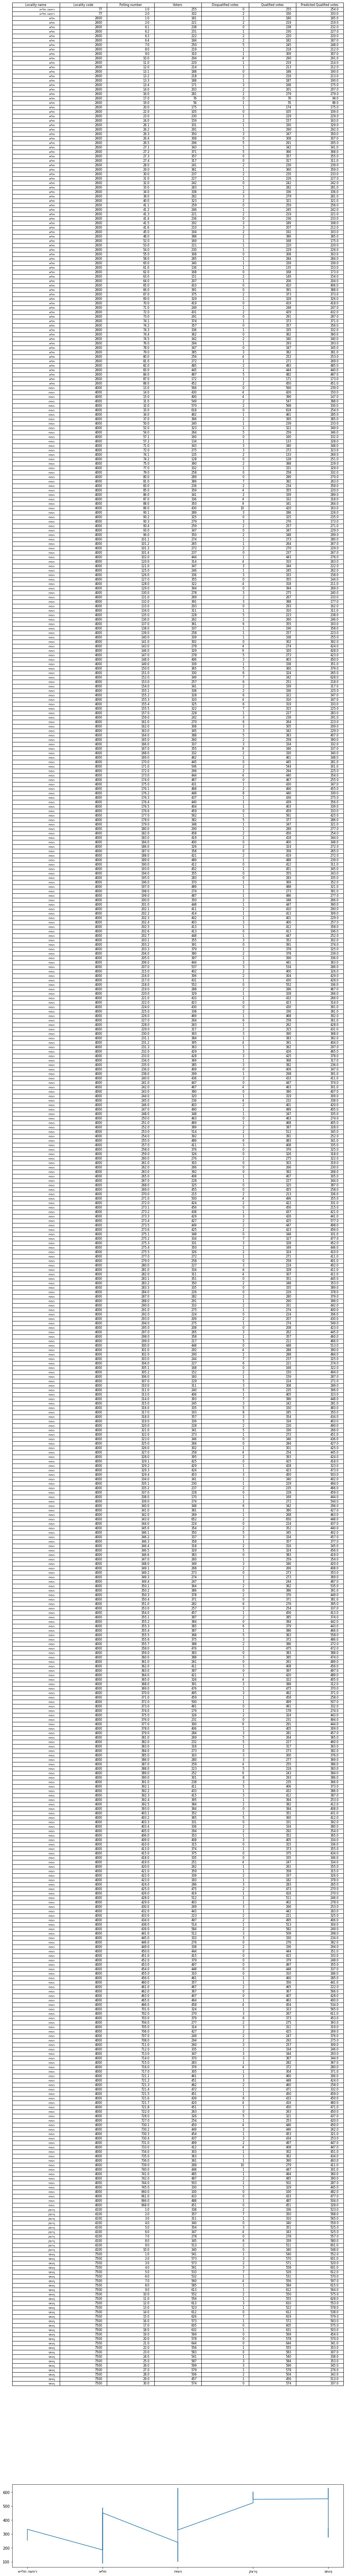

In [546]:
plt.close()


# plt.figure(figsize=(16,9))
plt.rcParams["figure.figsize"] = [16,9]
fig, axs = plt.subplots(2,1)
axs[0].axis('tight')
axs[0].axis('off')
the_table = axs[0].table(cellText=data_4,colLabels=columns_4_2,loc='top')

axs[1].plot(data_4[:,0],data_4[:,-1])
plt.show()

# 5) AdaBoost

In [547]:
adb = AdaBoostRegressor(random_state = RSEED)

# adb_param_grid = {'n_estimators':[50,100,150,200,250], #Number of weak learners to train iteratively., 
#                   'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
#                   'random_state': [1]}

adb_param_grid = {'n_estimators':[150,200,250], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                  'loss' : ['linear', 'square', 'exponential'],
                  'random_state': [1]}

# gsADB = GridSearchCV(adb,param_grid = adb_param_grid, cv=5, scoring="accuracy", n_jobs= -1)

gsADB1 = GridSearchCV(adb,param_grid = adb_param_grid, cv=5, n_jobs= -1)
gsADB2 = GridSearchCV(adb,param_grid = adb_param_grid, cv=5, n_jobs= -1)
gsADB3 = GridSearchCV(adb,param_grid = adb_param_grid, cv=5, n_jobs= -1)
# gsADB2 = GridSearchCV(adb,param_grid = adb_param_grid, cv=10) #, n_jobs= -1)


# gsADB.fit(X_5_train,y_5_train)
# gsADB.best_params_
# ADB_best = gsADB.best_estimator_



In [620]:
# columns_5 = ( 'Karmeil', 'Sakhnin', , 'Bni-Brak',  'Daliet Al Karmel', 'Jerusalem')
columns_5 = ( 'Bni-Brak',  'Daliet Al Karmel', 'Jerusalem', 'Karmeil', 'Sakhnin')

## With polling numbers
# df_b_23_filtered = df_b_23.loc[df_b_23['שם ישוב'].isin(['ירושלים', 'סחנין', 'בני ברק', 'דאלית אלכרמל', 'כרמיאל'])]
# X_5_filtered = df_b_23_filtered.values #.drop(['שם ישוב'], axis=1).values

# Only locality without kalpi
# df_c_5_filtered = df_c_23.loc[df_c_23['שם ישוב'].isin(['ירושלים', 'סחנין', 'בני ברק', 'דאלית אלכרמל', 'כרמיאל'])]#.sort_values(['סמל ישוב'], ascending=[True])
# X_5_filtered = df_c_5_filtered.values #.drop(['שם ישוב'], axis=1).values

# print(X_5_filtered.shape, X_5_filtered)

# Get indexes of filtered rows - to be used later on fo filtering predictions
df_c_5_filtered = df_test_locality.loc[df_test_locality['Locality Name'].isin(['ירושלים', 'סחנין', 'בני ברק', 'דאלית אלכרמל', 'כרמיאל'])] 
# df_c_5_filtered.index
df_c_5_filtered

,committee code,Locality Name,Locality Code,BzB,Voters,Disqualified,Qualified,1,2,3,...,51,52,53,54,55,56,57,58,59,60
196,15,בני ברק,6100,111344,85775,929,84846,1133,0,51922,...,0,0,0,0,0,7,0,0,4,2
321,8,דאלית אלכרמל,494,12693,7150,48,7102,5200,0,1,...,0,0,0,0,0,1,0,0,1,6
494,1,ירושלים,3000,415991,263214,1625,261589,32800,0,63782,...,0,0,0,0,0,183,0,0,8,25
607,6,כרמיאל,1139,41328,24537,167,24370,6627,0,807,...,0,0,0,0,0,24,0,0,2,7
870,6,סחנין,7500,21624,17136,51,17085,120,0,9,...,0,0,0,0,0,1,0,0,0,3


In [613]:
# TODO - Check Arab Common List votes
df_5_train = df_train_locality[["Locality Code", "Voters", "Qualified", "Disqualified", party2code["מחל"], party2code["ודעם"], party2code["פה"]]]
df_5_train.head()

,Locality Code,Voters,Qualified,Disqualified,45,32,1
0,7,371,371,0,141,0,99
1,10,237,235,2,124,0,5
2,11,289,288,1,84,0,111
3,13,403,403,0,26,0,250
4,15,217,215,2,165,0,5


In [614]:
df_5_test = df_test_locality[["Locality Code", "Voters", "Qualified", "Disqualified", party2code["מחל"], party2code["ודעם"], party2code["פה"]]]
df_5_test.head()

,Locality Code,Voters,Qualified,Disqualified,45,32,1
0,967,595,589,6,4,554,8
1,472,2718,2682,36,280,2157,123
2,473,6090,6037,53,190,4458,752
3,958,41,40,1,0,40,0
4,968,1336,1328,8,8,1263,33


## Likud votes

In [592]:
# y_Likud_train = X[:, [28]] # Likud votes 
# X_Likud_train = np.delete(X[:, 3:],[28],1) # Without Likud data            

## With polling numbers
# X_Likud_train = np.concatenate((X_train_polling[:, 3:27],X_train_polling[:, 29:]), axis=1) # Without Likud data
# X_Likud_train = X_train_polling[:, 3:11]
# y_Likud_train = X_train_polling[:, [28]] # Likud votes

# With localities only
# X_Likud_train = X_train_locality[:, 2:5]
# y_Likud_train = X_train_locality[:, 24] # Likud votes
X_Likud_train = df_5_train.values[:, :4]
y_Likud_train = df_5_train.values[:, 4] # Likud votes

y_Likud_train = y_Likud_train.astype('int')

print("X_Likud_train: \n", X_Likud_train.shape, X_Likud_train)
print("y_Likud_train: \n", y_Likud_train.shape, y_Likud_train)

X_Likud_train: 
 (2428, 4) [[     7    371    371      0]
 [    10    237    235      2]
 [    11    289    288      1]
 ...
 [  9700  34603  34505     98]
 [  9800   7536   7515     21]
 [  9999 282442 280216   2226]]
y_Likud_train: 
 (2428,) [141 124  84 ...   0  40 254]


In [583]:
gsADB1.fit(X_Likud_train,y_Likud_train)
print("Best Parameters:\n", gsADB1.best_params_)
ADB_best_likud = gsADB1.best_estimator_

adb_Likud = AdaBoostRegressor(ADB_best_likud)
adb_Likud.fit(X_Likud_train,y_Likud_train)

adb_Likud.feature_importances_

C:\Users\MuhammadZbeedat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:
 {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 150, 'random_state': 1}


array([0.12861752, 0.24084365, 0.22849009, 0.40204874])

In [593]:
## With Polling - filtered
# X_Likud_test = X_5_filtered[:, 3:11]
# y_Likud_test = X_5_filtered[:, 28] # Likud votes

## Only localities - filtered
# X_Likud_test = X_5_filtered[:, 2:5]
# y_Likud_test = X_5_filtered[:, 23] # Likud votes
## y_Likud_test = y_Likud_test[::-1] # reverse it


## Without filtering

# With Polling numbers
# X_Likud_test = np.concatenate((X_test_polling[:, 3:26],X_test_polling[:, 28:]), axis=1) # Without Likud data
# X_Likud_test = X_test_polling[:, 3:11]
# y_Likud_test = X_test_polling[:, [27]] # Likud votes

# Without polling numbers
# X_Likud_test = X_test_locality[:, 2:7]
# y_Likud_test = X_test_locality[:, 23] # Likud votes
X_Likud_test = df_5_test.values[:, :4]
y_Likud_test = df_5_test.values[:, 4] # Likud votes

print("\nX_Likud_test: ",  X_Likud_test.shape, "\n", X_Likud_test)
print("\ny_Likud_test: ",  y_Likud_test.shape, "\n", y_Likud_test)


X_Likud_test:  (1214, 4) 
 [[ 967  595  589    6]
 [ 472 2718 2682   36]
 [ 473 6090 6037   53]
 ...
 [ 970   48   48    0]
 [1346  206  206    0]
 [ 778  472  471    1]]

y_Likud_test:  (1214,) 
 [  4 280 190 ...   0  40 254]


In [587]:
y_Likud_pred=adb_Likud.predict(X_Likud_test)

print('Mean Squared Error:', metrics.mean_squared_error(y_Likud_test, y_Likud_pred))

filtered_likud_pred = np.array(y_Likud_pred)[df_c_5_filtered.index] 
filtered_likud_labels = np.array(y_Likud_test)[df_c_5_filtered.index] 

print("\n")
print("Test labels: ", filtered_likud_labels.shape, filtered_likud_labels)
print("Predicted values: ", filtered_likud_pred.shape, filtered_likud_pred)

Mean Squared Error: 38960044.18744001


Test labels:  (5,) [ 4951   407 72601  8879    39]
Predicted values:  (5,) [12236.13011152  4596.53964194 22853.66666667  5574.05660377
  4173.30494505]


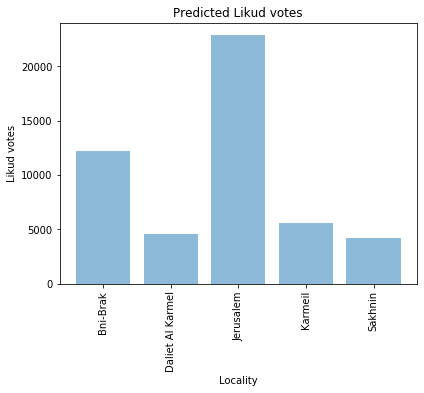

In [621]:

# plt.figure(8)
# plt.figure(figsize=(6.4,4.8))
# plt.scatter(X_Likud_test[:,0], y_Likud_pred, s=30, alpha=0.5)
# plt.title('Predicted votes for Likud')
# plt.xlabel('Test labels')
# plt.ylabel('Predicted labels')
# plt.show()

# plt.figure(9)
# plt.figure(figsize=(6.4,4.8))
# plt.plot(X_Likud_test[:,0], y_Likud_pred)
# plt.xlabel('Locality')
# plt.ylabel('Qualified votes')
# plt.title('Predicted qualified votes')
# plt.show()

# plt.figure(9)
plt.figure(figsize=(6.4,4.8))
y_pos = np.arange(len(columns_5))
plt.bar(y_pos, filtered_likud_pred, align='center', alpha=0.5)
plt.xticks(y_pos, columns_5, rotation='vertical')
plt.xlabel('Locality')
plt.ylabel('Likud votes')
plt.title('Predicted Likud votes')
plt.show()


## Arabs Common List votes

In [598]:
# X_ArabList_train = np.delete(X[:, 3:],[13],1) # Without ArabicCommonList data
# y_ArabList_train = X[:, [13]] # ArabicCommonList votes              

## With polling numbers
# X_ArabList_train = X_train_polling[:, 3:11]
# y_ArabList_train = X_train_polling[:, [13]] # Likud votes

## With localities only
# X_ArabList_train = X_train_locality[:, 2:5]
# y_ArabList_train = X_train_locality[:, 9] # Arab List votes
X_ArabList_train = df_5_train.values[:, :4]
y_ArabList_train = df_5_train.values[:, 5] # Arab List votes

y_ArabList_train = y_ArabList_train.astype('int')

print("X_ArabList_train: \n", X_ArabList_train.shape, X_ArabList_train)
print("\n\ny_ArabList_train: \n", y_ArabList_train.shape, y_ArabList_train)

X_ArabList_train: 
 (2428, 4) [[     7    371    371      0]
 [    10    237    235      2]
 [    11    289    288      1]
 ...
 [  9700  34603  34505     98]
 [  9800   7536   7515     21]
 [  9999 282442 280216   2226]]


y_ArabList_train: 
 (2428,) [  0   0   0 ...  43 160   0]


In [599]:
gsADB2.fit(X_ArabList_train,y_ArabList_train)
print("Best Parameters:\n", gsADB2.best_params_)
ADB_best_ArabList = gsADB2.best_estimator_

adb_ArabList = AdaBoostRegressor(ADB_best_ArabList)
adb_ArabList.fit(X_ArabList_train,y_ArabList_train.astype(float))

adb_ArabList.feature_importances_

C:\Users\MuhammadZbeedat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:
 {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 150, 'random_state': 1}


array([0.51232095, 0.16704885, 0.22890326, 0.09172694])

In [600]:
## With Pollings
# X_ArabList_test = np.delete(X_23_filtered[:, 3:],[28],1) # Without Likud data  
# y_ArabList_test = X_23_filtered[:, 28] # Likud votes

## With Polling - filtered with specific localities
# X_ArabList_test = X_5_filtered[:, 3:11]
# y_ArabList_test = X_5_filtered[:, 13] # Likud votes

## Only localities - filtered by specific localities
# X_ArabList_test = X_5_filtered[:, 2:5]
# y_ArabList_test = X_5_filtered[:, 9] # Likud votes

# X_ArabList_test = X_test_polling[:, 3:11]
# y_ArabList_test = X_test_polling[:, [13]] # Likud votes

# X_ArabList_test = X_test_locality[:, 2:7]
# y_ArabList_test = X_test_locality[:, 9] # Likud votes

X_ArabList_test = df_5_test.values[:, :4]
y_ArabList_test = df_5_test.values[:, 5] # Arab List votes

print("X_ArabList_test: ",  X_ArabList_test.shape, "\n", X_ArabList_test)
print("y_ArabList_test: ",  y_ArabList_test.shape, y_ArabList_test)

X_ArabList_test:  (1214, 4) 
 [[ 967  595  589    6]
 [ 472 2718 2682   36]
 [ 473 6090 6037   53]
 ...
 [ 970   48   48    0]
 [1346  206  206    0]
 [ 778  472  471    1]]
y_ArabList_test:  (1214,) [ 554 2157 4458 ...   43  160    0]


In [610]:
y_ArabList_pred=adb_ArabList.predict(X_ArabList_test)

print('Mean Squared Error:', metrics.mean_squared_error(y_ArabList_test, y_ArabList_pred))


filtered_ArabList_pred = np.array(y_ArabList_pred)[df_c_5_filtered.index] 
filtered_ArabList_labels = np.array(y_ArabList_test)[df_c_5_filtered.index] 

print("\n")
print("Test labels: ", filtered_ArabList_labels.shape, filtered_ArabList_labels)
print("Predicted values: ", filtered_likud_pred.shape, filtered_likud_pred)

Mean Squared Error: 6866583.92639547


Test labels:  (5,) [   22   650  5321   468 16610]
Predicted values:  (5,) [12236.13011152  4596.53964194 22853.66666667  5574.05660377
  4173.30494505]


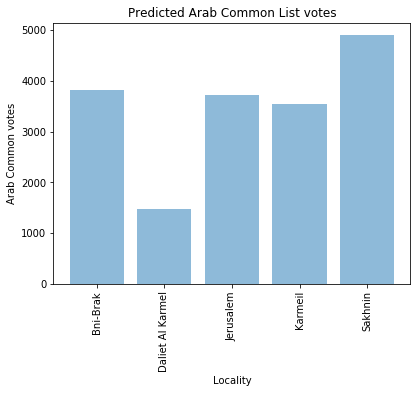

In [622]:
# plt.figure(1)
# plt.figure(figsize=(6.4,4.8))
# plt.scatter(y_ArabList_test, y_ArabList_pred, s=30, alpha=0.5)
# plt.title('Predicted Arab Common List votes')
# plt.xlabel('Test labels')
# plt.ylabel('Predicted labels')
# plt.show()

# plt.figure(2)
# plt.figure(figsize=(6.4,4.8))
# plt.plot(X_ArabList_test[:, 0], y_ArabList_pred) #X_4_test_polling[:, 0]
# plt.xlabel('Locality')
# plt.ylabel('Likud votes')
# plt.title('Predicted Arab Common List votes')
# plt.show()

plt.figure(figsize=(6.4,4.8))
y_pos = np.arange(len(columns_5))
plt.bar(y_pos, filtered_ArabList_pred, align='center', alpha=0.5)
plt.xticks(y_pos, columns_5, rotation='vertical')
plt.xlabel('Locality')
plt.ylabel('Arab Common votes')
plt.title('Predicted Arab Common List votes')
plt.show()

## Blue and White votes

In [603]:
# X_BlueWhite_train = np.delete(X[:, 3:],[33],1) # Without BlueWhite data
# y_BlueWhite_train = X[:, [33]] # BlueWhite votes              

# X_BlueWhite_train = X_train_locality[:, 2:7]
# y_BlueWhite_train = X_train_locality[:, 29] # BlueWhite votes

X_BlueWhite_train = df_5_train.values[:, :4]
y_BlueWhite_train = df_5_train.values[:, 6] # BlueWhite votes

y_BlueWhite_train = y_BlueWhite_train.astype('int')

print("X_BlueWhite_train: \n", X_BlueWhite_train.shape, X_BlueWhite_train)
print("y_BlueWhite_train: \n", y_BlueWhite_train.shape, y_BlueWhite_train)

X_BlueWhite_train: 
 (2428, 4) [[     7    371    371      0]
 [    10    237    235      2]
 [    11    289    288      1]
 ...
 [  9700  34603  34505     98]
 [  9800   7536   7515     21]
 [  9999 282442 280216   2226]]
y_BlueWhite_train: 
 (2428,) [ 99   5 111 ...   4   2  65]


In [604]:
gsADB3.fit(X_BlueWhite_train,y_BlueWhite_train)
print("Best Parameters:\n", gsADB3.best_params_)
ADB_best_BlueWhite = gsADB3.best_estimator_

adb_BlueWhite = AdaBoostRegressor(ADB_best_BlueWhite)
adb_BlueWhite.fit(X_BlueWhite_train,y_BlueWhite_train.astype(float))

adb_BlueWhite.feature_importances_

C:\Users\MuhammadZbeedat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:
 {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 150, 'random_state': 1}


array([0.15806207, 0.30157947, 0.3003173 , 0.24004116])

In [605]:
## With polling numbers
# X_BlueWhite_test = np.delete(X_23_filtered[:, 3:],[28],1) # Without Likud data  
# y_BlueWhite_test = X_23_filtered[:, 28] # BlueWhite votes

## Only localities - filtered
# X_BlueWhite_test = X_5_filtered[:, 2:7]
# y_BlueWhite_test = X_5_filtered[:, 29] # BlueWhite votes

# With localities only
# X_BlueWhite_test = X_test_locality[:, 2:7]
# y_BlueWhite_test = X_test_locality[:, 32] # BlueWhite votes
X_BlueWhite_test = df_5_test.values[:, :4]
y_BlueWhite_test = df_5_test.values[:, 6] # BlueWhite votes

print("X_BlueWhite_test: ",  X_BlueWhite_test.shape, "\n", X_BlueWhite_test)
print("\n\ny_BlueWhite_test: ",  y_BlueWhite_test.shape, y_BlueWhite_test)

X_BlueWhite_test:  (1214, 4) 
 [[ 967  595  589    6]
 [ 472 2718 2682   36]
 [ 473 6090 6037   53]
 ...
 [ 970   48   48    0]
 [1346  206  206    0]
 [ 778  472  471    1]]


y_BlueWhite_test:  (1214,) [  8 123 752 ...   4   2  65]


In [609]:
y_BlueWhite_pred=adb_BlueWhite.predict(X_BlueWhite_test)

print('Mean Squared Error:', metrics.mean_squared_error(y_BlueWhite_test, y_BlueWhite_pred))

filtered_BlueWhite_pred = np.array(y_BlueWhite_pred)[df_c_5_filtered.index] 
filtered_BlueWhite_labels = np.array(y_BlueWhite_test)[df_c_5_filtered.index] 

print("\n")
print("Test labels: ", filtered_BlueWhite_labels.shape, filtered_BlueWhite_labels)
print("Predicted values: ", filtered_BlueWhite_pred.shape, filtered_BlueWhite_pred)

Mean Squared Error: 88518178.07256831


Test labels:  (5,) [ 1133  5200 32800  6627   120]
Predicted values:  (5,) [17608.39987715  9582.85714286 22478.61311475 15652.6763754
  9835.11557789]


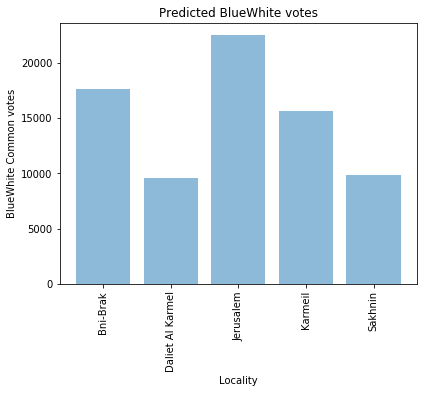

In [623]:
plt.figure(figsize=(6.4,4.8))
y_pos = np.arange(len(columns_5))
plt.bar(y_pos, filtered_BlueWhite_pred, align='center', alpha=0.5)
plt.xticks(y_pos, columns_5, rotation='vertical')
plt.xlabel('Locality')
plt.ylabel('BlueWhite Common votes')
plt.title('Predicted BlueWhite votes')
plt.show()

# 6) Predict where to locate supervisors

<b><u>Note:</u></b> I preffered working with data which includes localities information only without polling numbers

In [625]:
df_train_locality.head()

,committee code,Locality Name,Locality Code,BzB,Voters,Disqualified,Qualified,1,2,3,...,51,52,53,54,55,56,57,58,59,60
0,0,שחר,7,516,371,0,371,99,0,2,...,0,0,0,0,0,23,0,0,0,0
1,0,תירוש,10,333,237,2,235,5,0,3,...,0,0,0,0,0,4,0,0,0,0
2,0,"ניר ח""ן",11,403,289,1,288,111,0,0,...,0,0,0,0,0,17,0,0,0,0
3,0,חצבה,13,502,403,0,403,250,0,2,...,0,0,0,0,0,21,0,0,0,0
4,0,נועם,15,302,217,2,215,5,0,4,...,0,0,0,0,0,1,0,0,0,0


In [644]:
X_6_train = X_train_locality[:, [2, 3, 4, 6]] # 
y_6_train = X_train_locality[:, 5] #.ravel() # reshape from (n,1) to (n,) 

y_6_train = y_6_train.astype('int')

print("X_6_train: \n", X_6_train.shape, "\n",  X_6_train)
print("y_6_train: \n", y_6_train.shape, "\n", y_6_train)

X_6_train: 
 (1214, 4) 
 [[7 517 377 377]
 [10 332 245 245]
 [11 406 287 287]
 ...
 [9700 45835 34603 34505]
 [9800 10142 7536 7515]
 [9999 0 282442 280216]]
y_6_train: 
 (1214,) 
 [   0    0    0 ...   98   21 2226]


In [645]:

X_6_test = X_test_locality[:, [2, 3, 4, 6]] #.reshape(-1, 1) 
y_6_test = X_test_locality[:, 5] # קולות פסולים


print("X_6_test: \n",  X_6_test.shape, "\n", X_6_test)
print("\ny_6_test: \n",  y_6_test.shape, "\n", y_6_test)

X_6_test: 
 (1214, 4) 
 [[967 2018 595 589]
 [472 4821 2718 2682]
 [473 9422 6090 6037]
 ...
 [970 520 48 48]
 [1346 587 206 206]
 [778 576 472 471]]

y_6_test: 
 (1214,) 
 [6 36 53 ... 0 0 1]


In [787]:
df_6_filtered = df_c_23.loc[df_c_23['פסולים']>THRESHOLD]
# print(df_6_filtered)
df_table = df_6_filtered.iloc[:, [1, 2, 4, 5]] #.sort_values(['סמל ישוב'], ascending=[True]) #.reset_index()
# columns_6 = df_table.columns
# print(columns)

columns_6_disqualified = ['Locality name', 'Locality code', 'Voters', 'Disqualified votes', 'Predicted Disqualified votes']

## Filter predicted values by the indexes of filtered rows
# filtered_predicted_labels = rf_predictions_regressor[np.where( rf_predictions_regressor > THRESHOLD )] 
filtered_predicted_labels = np.array(rf_predictions_regressor)[df_6_filtered.index] 

data_6 = df_table.values
print(data_6.shape)
# data_6 = data_6[:, :-1]
data_6 = np.concatenate((data_6, filtered_predicted_labels.reshape(-1, 1)), axis=1)
# print(data)

(117, 4)


1) Build a RandomForest Regressor for predicting disqualified votes

In [697]:
# Regressor RandomForest (from section #4)
gs3 = GridSearchCV(estimator, param_grid, cv=10)

# Fit using Regressor RandomForest
gs3.fit(X_6_train, y_6_train)

gs3.best_params_

C:\Users\MuhammadZbeedat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\MuhammadZbeedat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 150}

In [698]:
best_model_regressor = gs3.best_estimator_

rf_predictions_regressor = best_model_regressor.predict(X_6_test)
# rf_predictions_regressor = np.around(rf_predictions_regressor, 0)

# rf_probs = best_model.predict_proba(X_6_test)[:, 1]
print("rf_predictions", rf_predictions_regressor.shape, rf_predictions_regressor)
# print("rf_probs", rf_probs.shape, rf_probs)

print('Mean Squared Error:', metrics.mean_squared_error(y_6_test, rf_predictions_regressor))

rf_predictions (1214,) [ 6 26 41 ...  0  5  0]
Mean Squared Error: 487.3657331136738


2) Converting predicted labels into True/False labels by checking if predicted disqualified votes are greater than a threshold

In [699]:
THRESHOLD = 30 # number of disqualified votes

train_labels = y_6_train > THRESHOLD
print(train_labels)

test_labels = rf_predictions_regressor > THRESHOLD
print(test_labels)

[False False False ...  True False  True]
[False False  True ... False False False]


3) Building a RandomForest classifier to predict if a SUPERVISOR is needed in localities with big amount of disqualified votes

In [700]:
# Estimator for use in grid search
estimator = RandomForestClassifier(random_state = RSEED)


# Create the random search model
# rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
#                         scoring = 'accuracy', cv = 5, 
#                         n_iter = 1, verbose = 1, random_state=RSEED)

gs4 = GridSearchCV(estimator, param_grid, cv=10)

# Fit 
gs4.fit(X_6_train, train_labels)
gs4.best_params_


{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 150}

In [702]:
best_model_classifier = gs4.best_estimator_

<Figure size 1152x648 with 0 Axes>

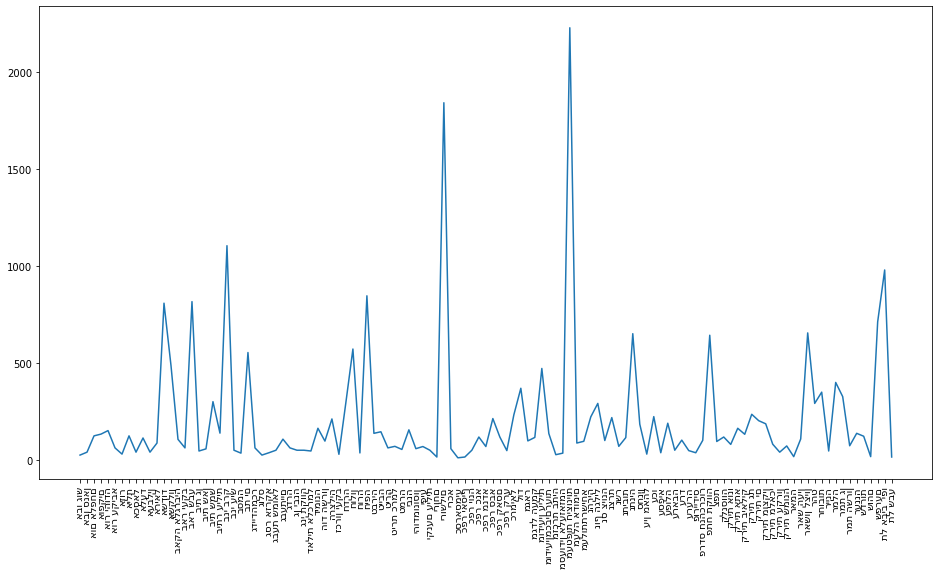

In [788]:
# plt.figure(5)
# plt.figure(figsize=(6.4,4.8))
# plt.plot(data_6[:, 0], filtered_predicted_labels)
# plt.xlabel('Locality')
# plt.ylabel('Disqualified votes')
# plt.title('Predicted Disqualified votes')
# plt.show()

plt.figure(6)
plt.figure(figsize=(16,9))
plt.plot(data_6[:, 0], filtered_predicted_labels)
# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(data_6[:, 0], data_6[:, 0], rotation='vertical')
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.05)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()

In [652]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

4) Make predictions and plot confusion matrix

Predictions:  [False False  True ... False False False]
Accuracy: 0.9892915980230642
Confusion matrix, without normalization
[[1085   10]
 [   3  116]]


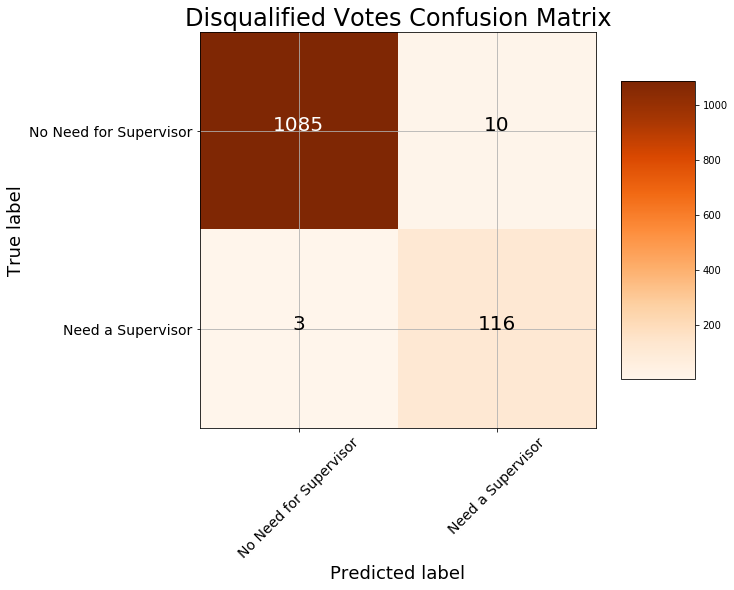

In [703]:
rf_predictions_classifier = best_model_classifier.predict(X_6_test)
rf_probs = best_model_classifier.predict_proba(X_6_test)[:, 1]
print("Predictions: ", rf_predictions_classifier)
print('Accuracy:', metrics.accuracy_score(test_labels, rf_predictions_classifier))

cm = confusion_matrix(test_labels, rf_predictions_classifier)

plot_confusion_matrix(cm, classes = ['No Need for Supervisor', 'Need a Supervisor'],
                      title = 'Disqualified Votes Confusion Matrix')

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

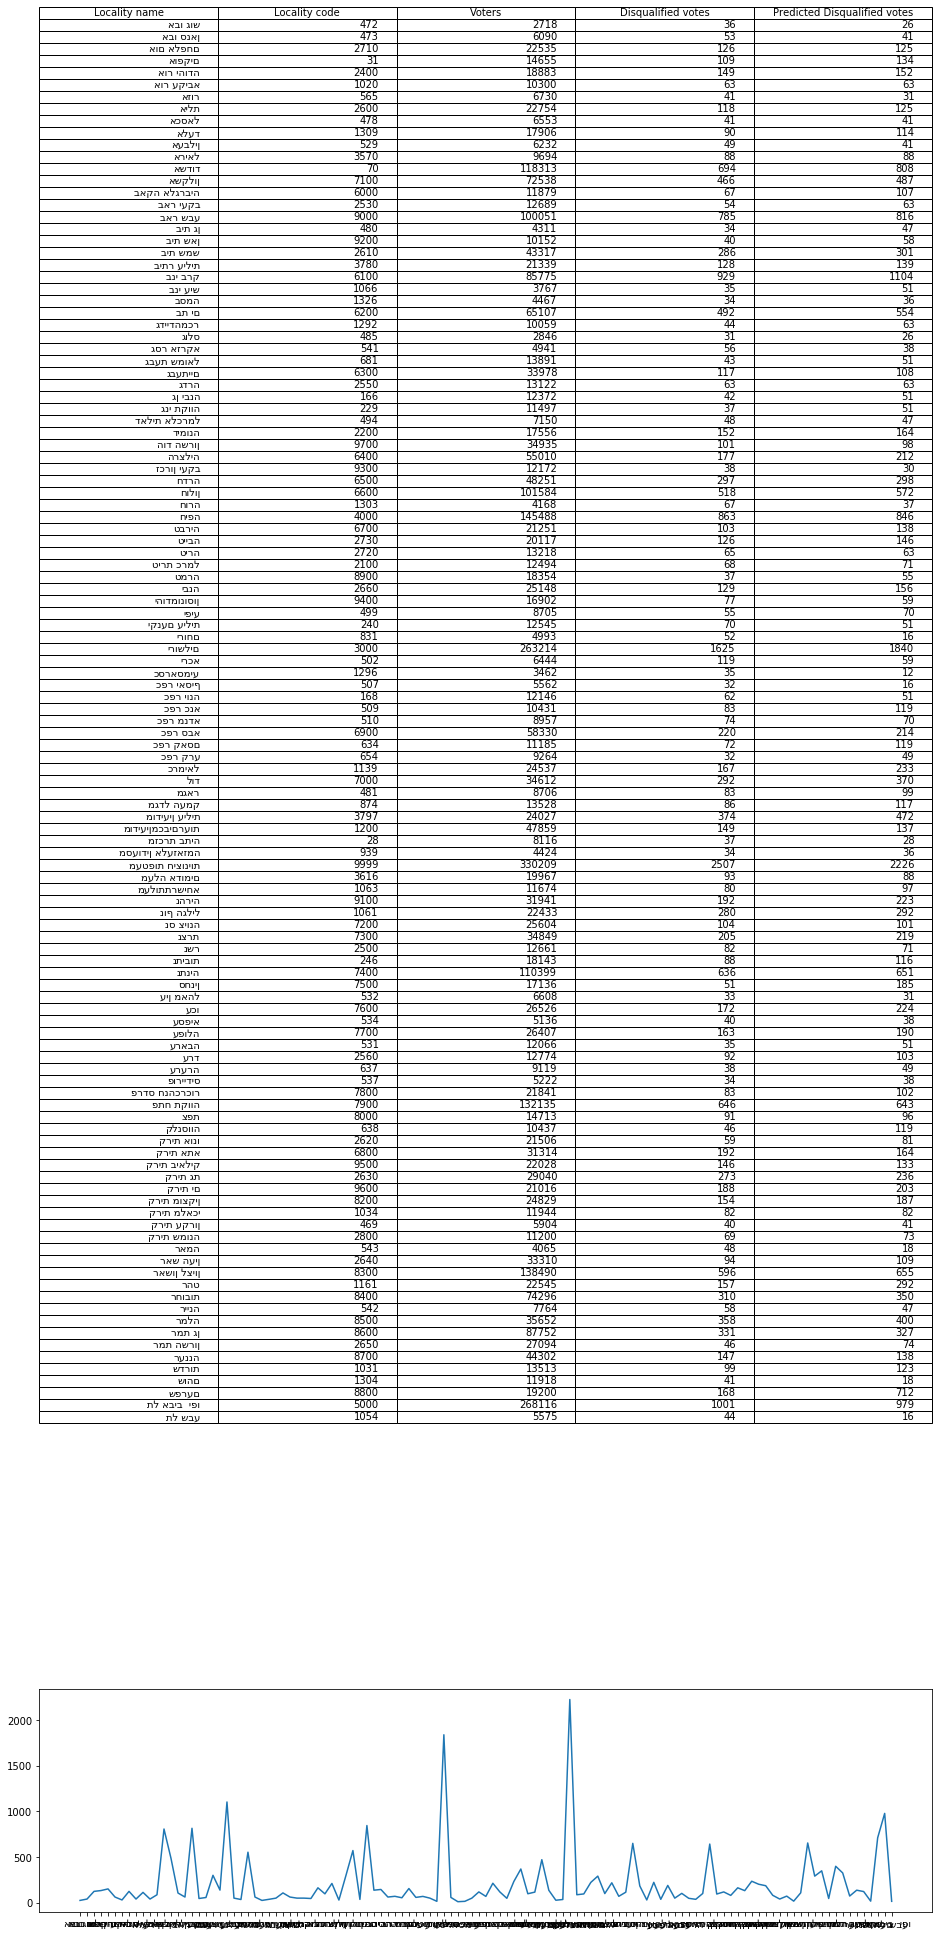

In [790]:
plt.figure(7)
plt.figure(figsize=(16,9))
fig, axs =plt.subplots(2,1)
axs[0].axis('tight')
axs[0].axis('off')
the_table = axs[0].table(cellText=data_6,colLabels=columns_6_disqualified,loc='top')

axs[1].plot(data_6[:,0],data_6[:,-1])
plt.show()

In [ ]:
.+